1. https://python-forum.io/Thread-Type-hinting-return-type-based-on-parameter

In [65]:
import inspect
from functools import wraps
from typing import Any

def set_type_as_var(variable_name):
    def decorator(f):
        @wraps(f)
        def wrapper(*args, **kwargs_inner):
            return f(*args, **kwargs_inner)
        
        desired_type = Any

        signature = inspect.getfullargspec(f)
        if signature.kwonlydefaults and variable_name in signature.kwonlydefaults:
            desired_type = type(signature.kwonlydefaults.get(variable_name))
            # probably, you can take into account signature.annotations ... 
            
        if signature.args and variable_name in signature.args:
            if signature.defaults is not None:
                desired_type = type(signature.defaults[signature.args.index(variable_name)])
            else:
                desired_type = signature.annotations.get(variable_name, Any)
            
        # maybe you will need other conditions .... 
        
        wrapper.__annotations__['return'] = desired_type
        return wrapper
    return decorator

In [66]:
@set_type_as_var('x')
def a(x:float):
    pass



/home/dmitry/.pyenv/versions/3.7.4/envs/scipy/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in cosh
/home/dmitry/.pyenv/versions/3.7.4/envs/scipy/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in cosh
/home/dmitry/.pyenv/versions/3.7.4/envs/scipy/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/home/dmitry/.pyenv/versions/3.7.4/envs/scipy/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/home/dmitry/.pyenv/versions/3.7.4/envs/scipy/lib/python3.7/site-packages/ipykernel_launcher.py:30: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/home/dmitry/.pyenv/versions/3.7.4/envs/scipy/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value enco

TypeError: 'numpy.float64' object is not callable

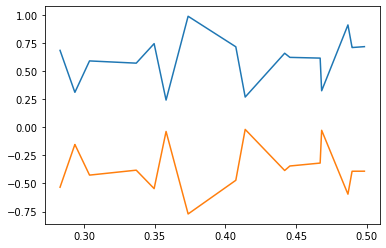

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# ODEpack tool for differential equation integration
from numpy.distutils.fcompiler import none
from scipy.integrate import odeint, quad
# Optimization tool
import scipy.optimize as opt
#Interpolation tool
from scipy.interpolate import interp1d
 
def Elliots_fit (p, a_exp , e):
    Eb, Eg, gamma, npc, k = p
    #Descrete transitions to the excitonic states
    absex = np.zeros((e.size))
    n = np.linspace(1, 500, 500)
    for i in range(0, e.size):
        expr = 4*np.pi*(Eb**(3/2)) / (n**3)*(1/(np.cosh((e[i] - Eg + Eb/n**2) / gamma)))
        S = expr.cumsum(axis=0)
        absex[i] = S[-1]
 
    #Band to band absorption with Sommerfeld correction
    abseh = np.zeros((e.size))
 
    def fun_eh(x, e, gamma, Eb, Eg, npc):
        D = (x-Eg)/Eb
        return (1 / (abs(np.cosh((e-x))/ gamma)) * 2 * np.pi * np.sqrt(Eb) / (1 - np.exp(-2 * np.pi / (np.sqrt(D)))) * 1 / (1 - npc * (x - Eg)))
 
    for i in range(0, e.size):
        q = quad(fun_eh, Eg, np.inf, args=(e[i], gamma, Eb, Eg, npc))
        abseh[i] = q[0]
    #Complete Abs simulation (background added)
    abs_sim = np.zeros((e.size))
    for i in range(0, e.size):
        abs_sim[i] = (e[i] / Eb**(3/2))*(absex[i] + abseh[i])
    return (abs_sim*k-abs_exp_fit)
 
#Data loading
#data = np.loadtxt('transmission_data.txt')
data = np.random.rand(100, 2)
# plt.plot(e, data[:,2])
e_exp = data [:,0] # concerted from nm to eV
a_exp = data[:,1] # My data
#Intial Values
Eb = 0.030 # exciton binding energy (eV)
gamma = 0.029 # inhomogeneous line broadening (eV)
Eg = 2.402 # semiconductor bandgap (eV)
npc = -0.31 # non−parabolic coefficient
k = 0.0035
#Energy axis generation
# ix0 = np.searchsorted(e_exp ,1.58862)
# ix1 = np.searchsorted(e_exp ,1.42976)
# e = np.linspace(e_exp[ix1], e_exp[ix0-1], 500) # energy axes (eV)
e = np.linspace(e_exp[len(e_exp)-1], e_exp[0], 3440) # energy axes (eV)
p0 = np.array([Eb, Eg, gamma, npc, k],dtype=np.float64 )#b = np.array([[1,2,3,4,5],[6,7,8,9,10]],dtype=np.float64)
#Fit Calling
#Interpolating the simulated abs over the exp x−axis
f = interp1d(e_exp ,a_exp)
abs_exp_fit = f(e)
opt_out = opt.leastsq(Elliots_fit ,p0, args =( abs_exp_fit , e), full_output=1)
fitted_param = opt_out[0]
#Standard error evaluation
 
fitting = Elliots_fit(fitted_param, abs_exp_fit, e)
 
plt.plot(e, abs_exp_fit)
plt.plot(e, fitting)
 
if (len( abs_exp_fit ) > len(p0)) and opt_out [1] is not None:
    s_sq = (( fitting-abs_exp_fit )**2).sum()((len( abs_exp_fit )-len(p0)))
    pcov = opt_out[1] * s_sq
else:
    pcov = np.inf
error = []
for i in range(len(opt_out [0])):
    try:
        error.append( np.absolute(pcov[i][i])**0.5)
    except:
        error.append( 0.00 )
pfit_leastsq = opt_out [0]
perr_leastsq = np.array(error)